# Read data

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models,datasets
from torch.utils.data import DataLoader 
from PIL import Image
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
train_dir ="./datasets/train"
valid_dir = "./datasets/valid"

In [3]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, variance=1.0, amplitude=1.0,p=0.5):
        self.mean = mean
        self.variance = variance
        self.amplitude = amplitude
        self.p = p

    def __call__(self, img):
        if random.uniform(0,1) <self.p:
            img = np.array(img)
            h, w, c = img.shape
            N = self.amplitude * np.random.normal(loc=self.mean, scale=self.variance, size=(h, w, 1))
            N = np.repeat(N, c, axis=2)
            img = N + img
            img[img > 255] = 255                    
            img = Image.fromarray(img.astype('uint8')).convert('RGB')
        return img

In [4]:
train_transform = transforms.Compose([
    transforms.Resize([64,64]),
    transforms.Grayscale(num_output_channels=3),
    transforms.ColorJitter(brightness=(0.8, 1.2),contrast=(0.6, 2)),
    AddGaussianNoise(mean=0, variance=random.uniform(0.1,0.5), amplitude=random.uniform(1,10),p=0.3),  
    transforms.RandomApply(torch.nn.ModuleList([ 
        transforms.GaussianBlur(5, sigma=(0.1,2)),
        transforms.RandomAffine(degrees=0,scale=(0.9, 1.1),translate=(0, 0.1)),
        transforms.RandomRotation(10),
    ])),
    
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomPerspective(distortion_scale=random.uniform(0,0.3), p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

valid_transform =  transforms.Compose([
        transforms.Resize([64,64]),
        transforms.Grayscale(num_output_channels=3),
        transforms.ColorJitter(contrast=(2, 2)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]) 


In [5]:
def load_data(data_dir,transform,batch_size,shuffle = True):
    m_dataset =  datasets.ImageFolder(data_dir,transform)
    m_dataloader = DataLoader(m_dataset,batch_size=batch_size,shuffle = shuffle )
    return m_dataloader
    

batch_size = 512

train_dataloader = load_data(train_dir,train_transform,64)
valid_dataloader = load_data(valid_dir,valid_transform,64,False)

class_names = train_dataloader.dataset.classes

# Load Model

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
class_size = len(train_dataloader.dataset.classes)
m_model = models.resnet152(weights = "ResNet152_Weights.DEFAULT")
m_model.fc = nn.Linear(m_model.fc.in_features,class_size)
if os.path.exists("save.pth"):
    m_model.load_state_dict(torch.load("save.pth"))
else:
    with open('example.txt', 'w') as file:
        file.write("train_loss,train_acc,valid_loss,valid_acc")


for p in m_model.parameters():
    p.requires_grad = False
    
for layer in [m_model.layer3.parameters(),m_model.layer4.parameters(),m_model.fc.parameters()]:
  for p in layer:
    p.requires_grad = True


m_model = m_model.to(device)


In [9]:
params_to_update = []
for param in m_model.parameters():
    if param.requires_grad ==True:
        params_to_update.append(param)

# Train Model

In [10]:
optimizer = torch.optim.Adam(params_to_update, lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size = 10,gamma = 0.99)
criterion = nn.CrossEntropyLoss()
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []


In [11]:
def train_model(model, train_data,valid_data, criterion, optimizer,device, num_epochs = 25):  
    for epoch in range(num_epochs):    
        print(f"[{epoch+1}/{num_epochs}]")
        epoch_loss,epoch_accuracy,epoch_time,current_lr = train(model, train_data, criterion, optimizer,device,True)
        torch.cuda.empty_cache()
        print(f"   Train: lr:{current_lr}, loss:{round(epoch_loss,4)}, accuracy: {round(epoch_accuracy*100,2)}%, time: {round(epoch_time,2)}s")
        
        with open('example.txt', 'a') as file:
            file.write(f"\n{epoch_loss},{epoch_accuracy},")
            
        
        epoch_loss,epoch_accuracy,epoch_time,current_lr = train(model, valid_data, criterion, optimizer,device,False)
        torch.cuda.empty_cache()
        print(f"   Valid: lr:{current_lr}, loss:{round(epoch_loss,4)}, accuracy: {round(epoch_accuracy*100,2)}%, time: {round(epoch_time,2)}s")        
        
        with open('example.txt', 'a') as file:
            file.write(f"{epoch_loss},{epoch_accuracy}")


def train(model, dataloader, criterion, optimizer,device,is_train):
    dataset_size =  len(dataloader.dataset)
    sum_loss = 0
    sum_correct_pred = 0 
    start_time = time.time()
    if is_train:
        model.train()
    else:
        model.eval()
    for inputs, labels in dataloader:    
        inputs=inputs.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if is_train:
            loss.backward()
            optimizer.step()

        _, preds = torch.max(outputs,1)
        sum_loss+= loss.item()*inputs.size(0)
        sum_correct_pred += torch.sum(preds == labels.data).item()
    epoch_loss = sum_loss / dataset_size
    epoch_accuracy = sum_correct_pred / dataset_size
    epoch_time = time.time() - start_time
    current_lr = optimizer.param_groups[0]['lr']
    if is_train:
        scheduler.step()
        torch.save(model.state_dict(), "save.pth")
    return epoch_loss, epoch_accuracy,epoch_time,current_lr


In [12]:
train_model(m_model, train_dataloader,valid_dataloader, criterion, optimizer,device,75)

[1/75]
   Train: lr:0.0001, loss:1.8813, accuracy: 47.43%, time: 282.35s
   Valid: lr:0.0001, loss:2.0737, accuracy: 46.93%, time: 14.21s
[2/75]
   Train: lr:0.0001, loss:1.105, accuracy: 67.97%, time: 267.38s
   Valid: lr:0.0001, loss:1.6006, accuracy: 56.08%, time: 14.37s
[3/75]
   Train: lr:0.0001, loss:0.8572, accuracy: 75.3%, time: 240.53s
   Valid: lr:0.0001, loss:1.3611, accuracy: 63.66%, time: 12.88s
[4/75]
   Train: lr:0.0001, loss:0.6698, accuracy: 80.51%, time: 255.34s
   Valid: lr:0.0001, loss:1.2836, accuracy: 65.62%, time: 14.54s
[5/75]
   Train: lr:0.0001, loss:0.5377, accuracy: 84.02%, time: 258.01s
   Valid: lr:0.0001, loss:1.3032, accuracy: 66.54%, time: 14.73s
[6/75]
   Train: lr:0.0001, loss:0.4487, accuracy: 86.65%, time: 269.88s
   Valid: lr:0.0001, loss:1.1911, accuracy: 69.41%, time: 14.24s
[7/75]
   Train: lr:0.0001, loss:0.3683, accuracy: 88.66%, time: 269.25s
   Valid: lr:0.0001, loss:1.1885, accuracy: 70.33%, time: 14.48s
[8/75]
   Train: lr:0.0001, loss:0.3

# Evaluate Model

In [13]:
def test_model(model, dataloader,device):
    model.eval()
    sum_correct_pred = 0
    sum_preds = None 

    for inputs, labels in dataloader:
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs = model(inputs)  
        _, preds = torch.max(outputs,1)    
        sum_correct_pred += torch.sum(preds == labels.data).item()
        if sum_preds == None:
            sum_preds =  preds
        else:
            sum_preds =torch.cat([sum_preds,preds])
        
    accuracy = sum_correct_pred / len(dataloader.dataset) 
    print(f"accuracy: {round(accuracy*100,2)}%")
    return sum_preds.cpu().numpy()



In [14]:
preds = test_model(m_model,valid_dataloader,device)

accuracy: 75.69%


In [15]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues): 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = ".2f"
    else:
        fmt = "d"
    plt.figure(figsize=(16, 12)) 
    plt.title(title)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt), fontsize=7 ,horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('Actual')
    plt.xlabel('Predict')
    plt.show()

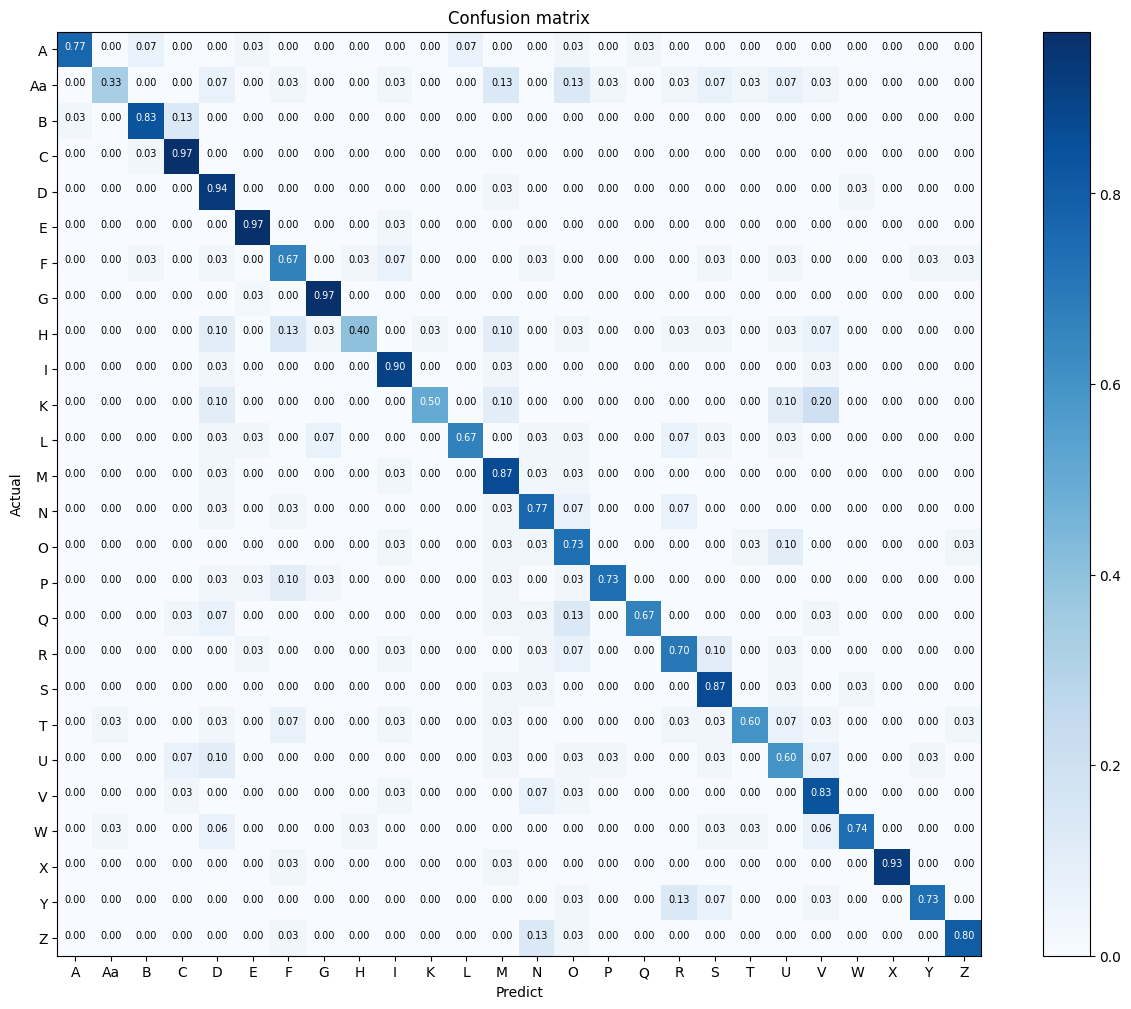

In [16]:
actual_result = []
for data in valid_dataloader.dataset:
    actual_result.append(data[1])
actual_result = np.array(actual_result)
plot_confusion_matrix(confusion_matrix(actual_result, preds),class_names)

In [29]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
precision = accuracy_score(actual_result,  preds )
precision

0.7568627450980392

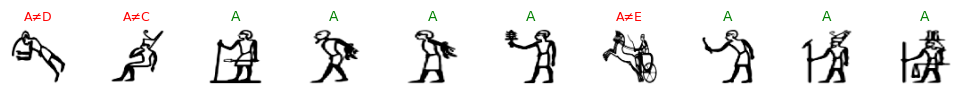

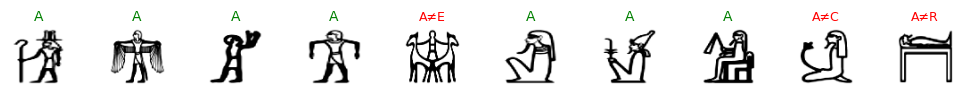

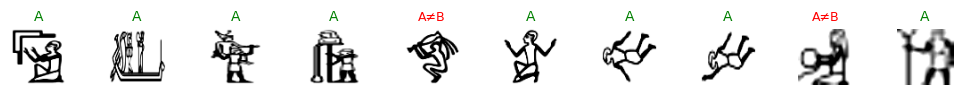

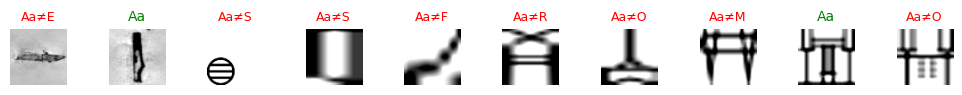

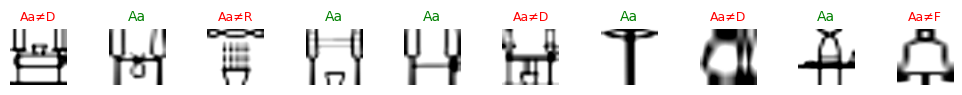

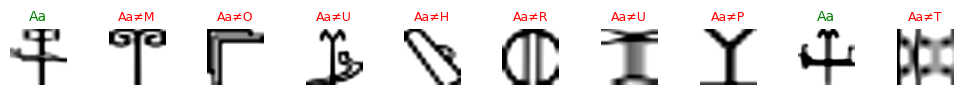

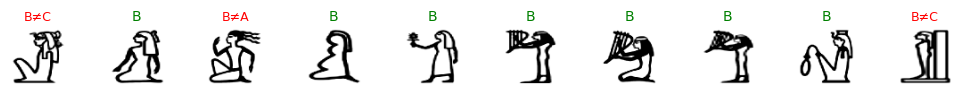

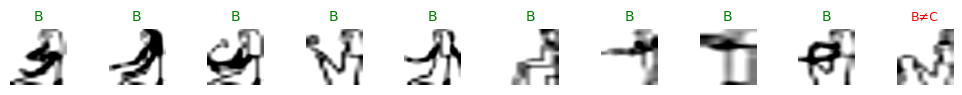

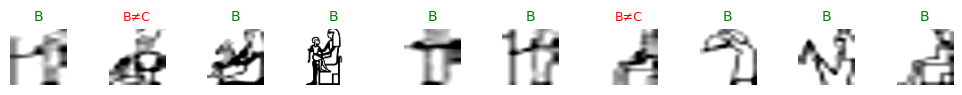

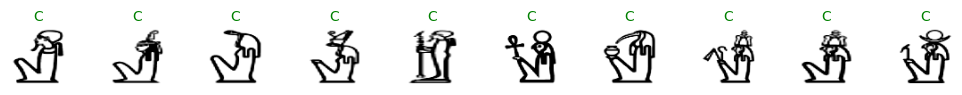

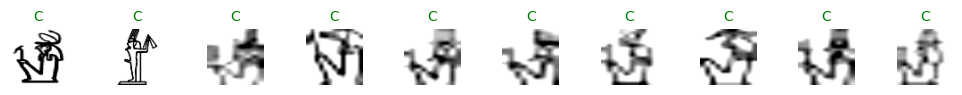

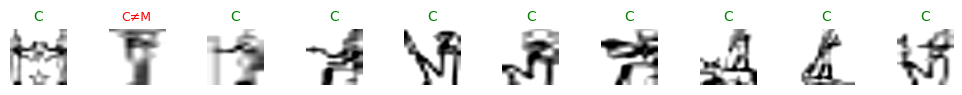

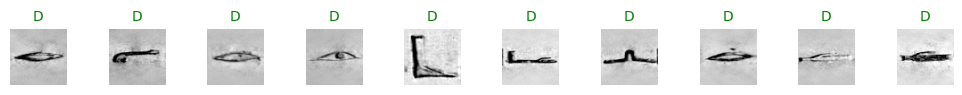

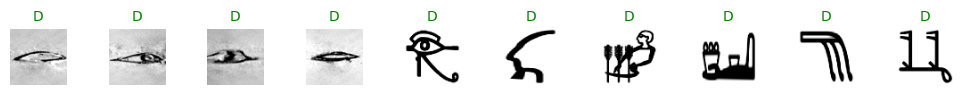

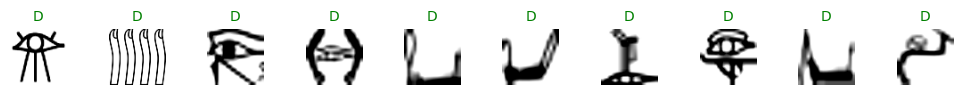

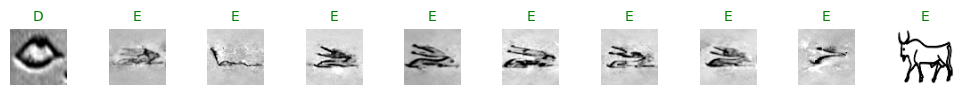

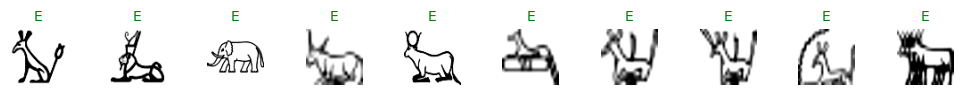

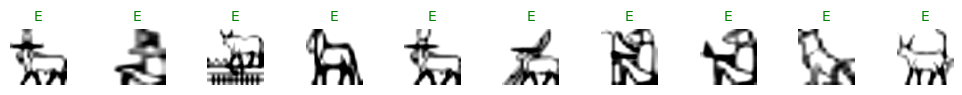

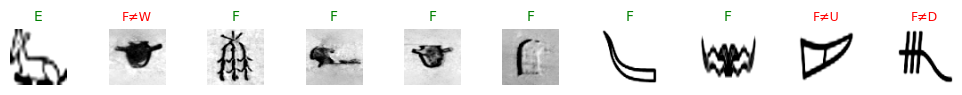

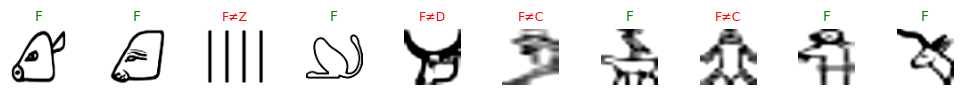

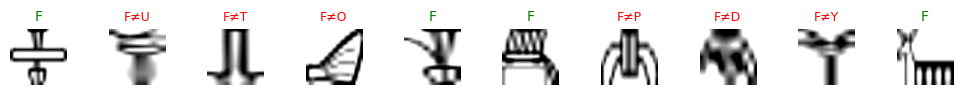

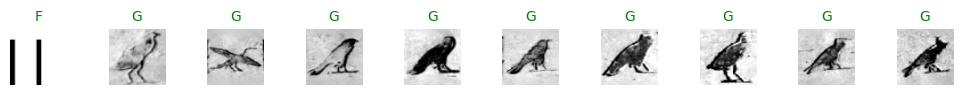

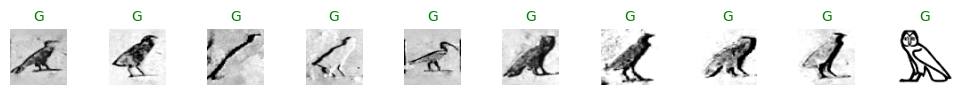

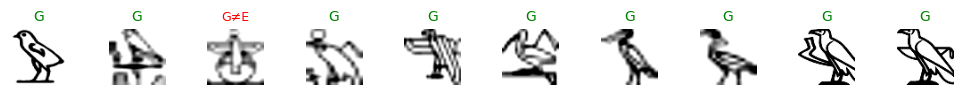

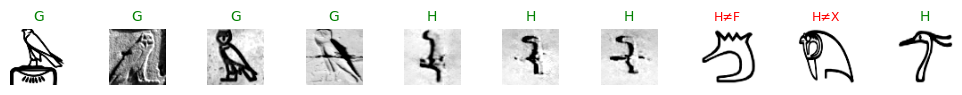

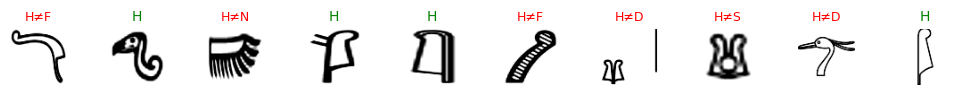

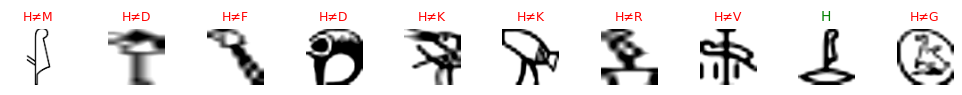

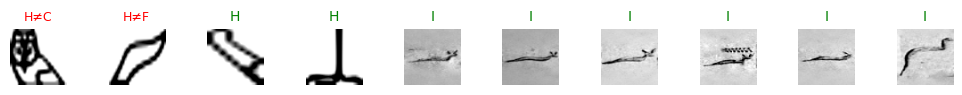

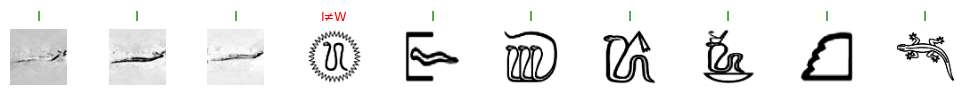

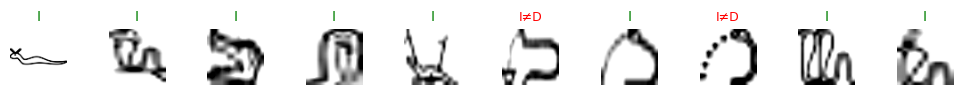

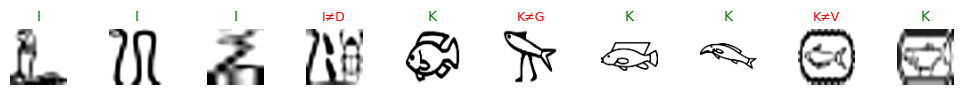

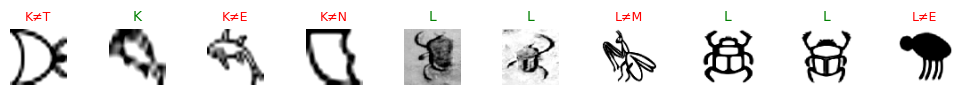

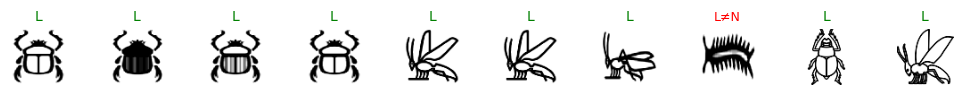

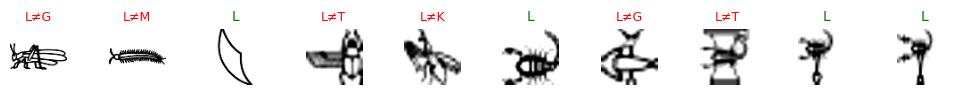

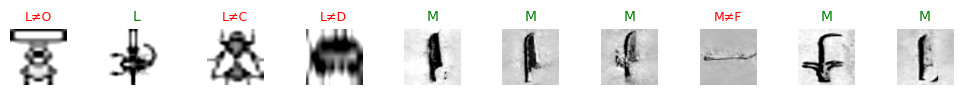

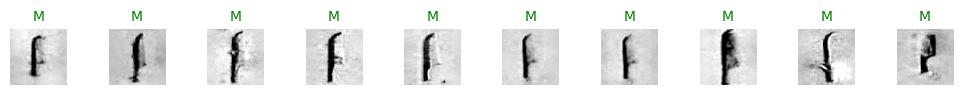

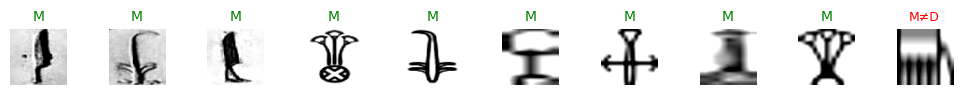

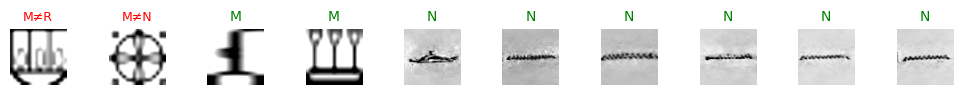

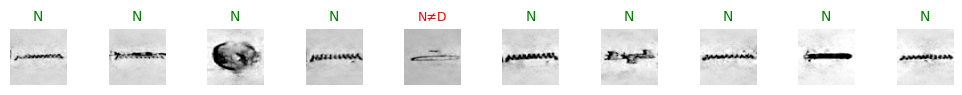

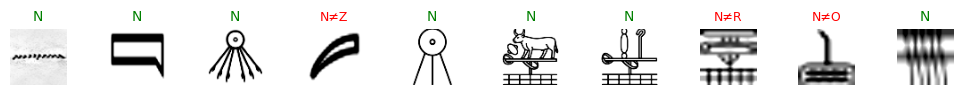

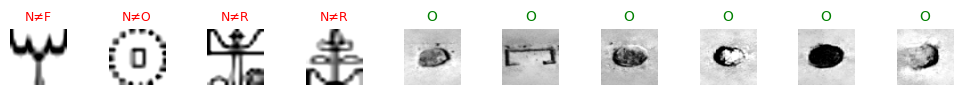

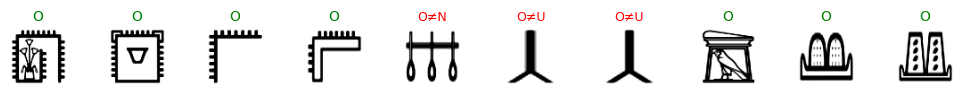

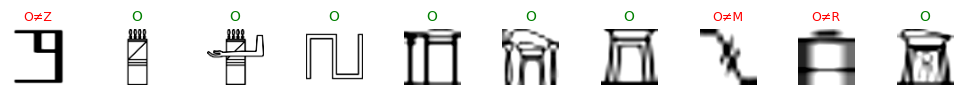

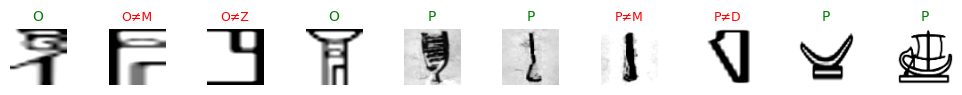

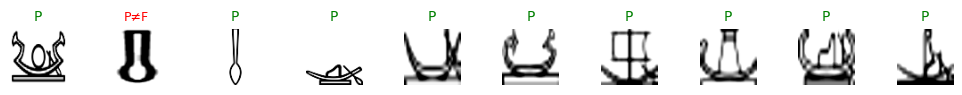

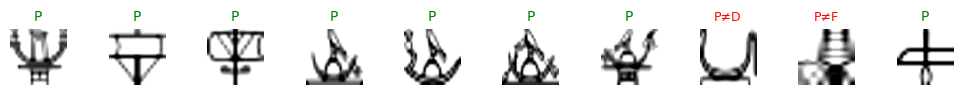

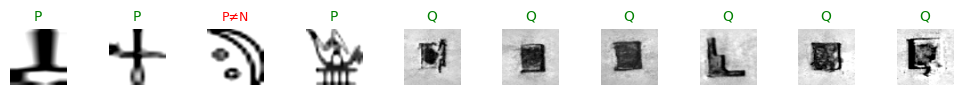

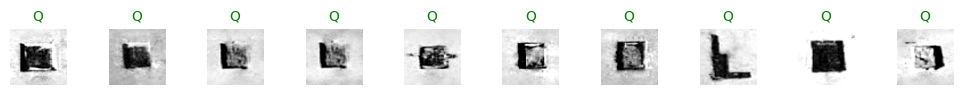

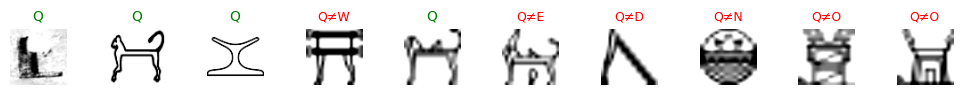

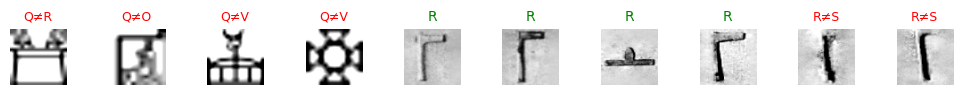

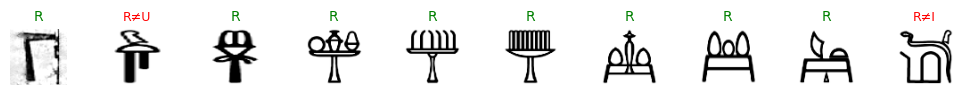

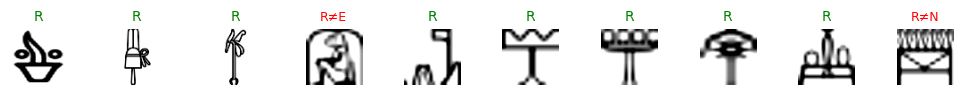

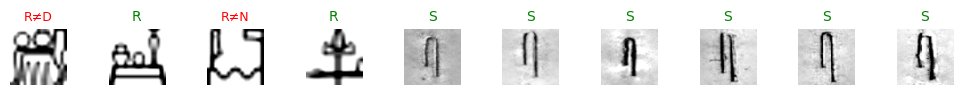

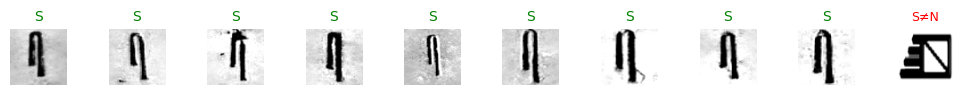

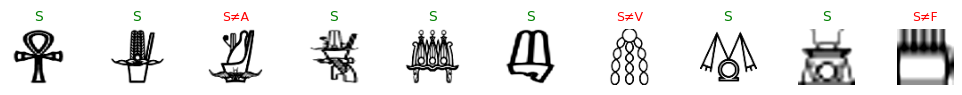

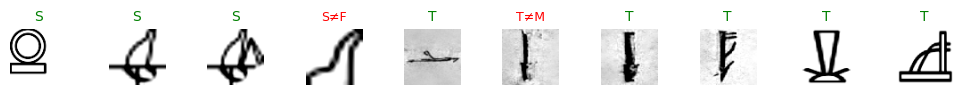

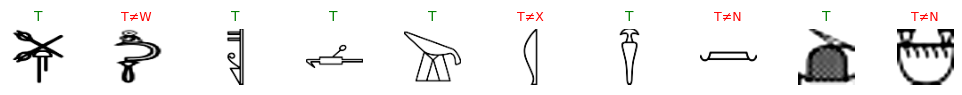

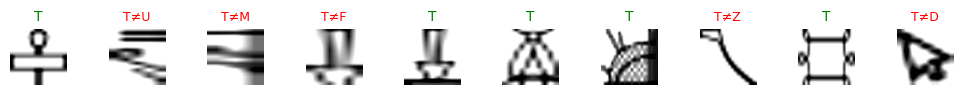

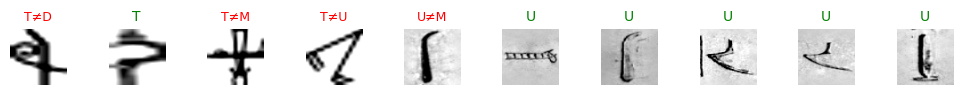

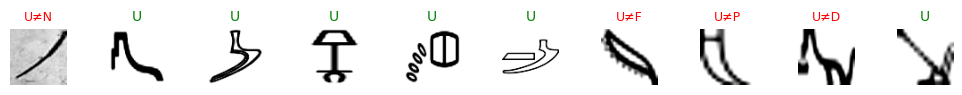

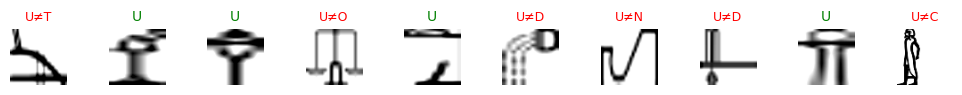

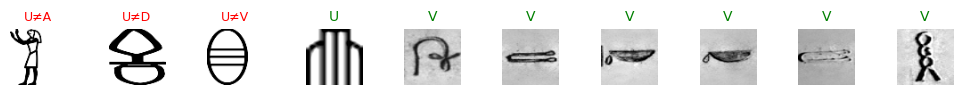

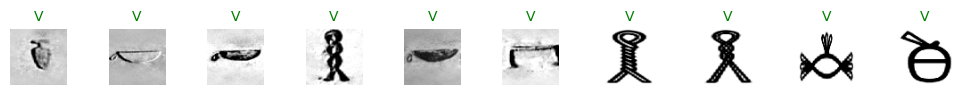

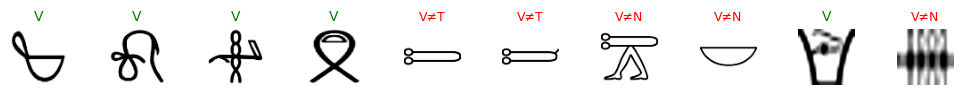

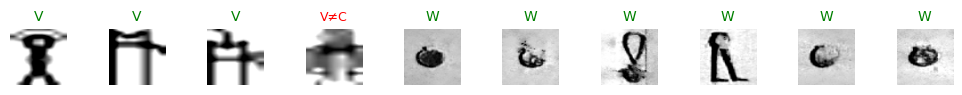

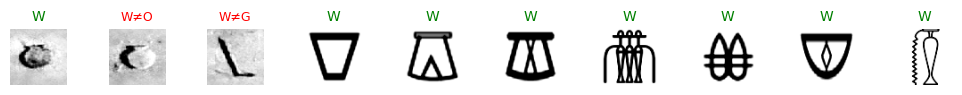

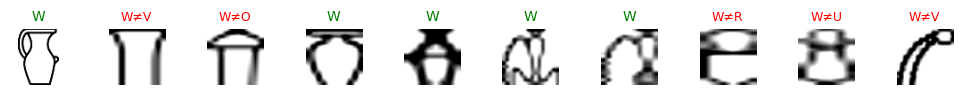

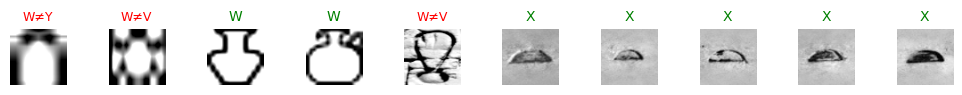

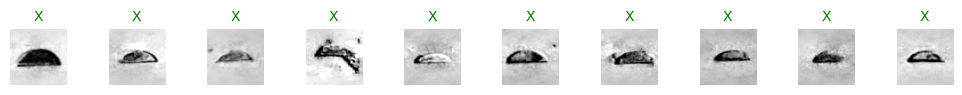

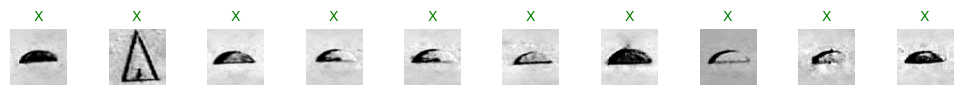

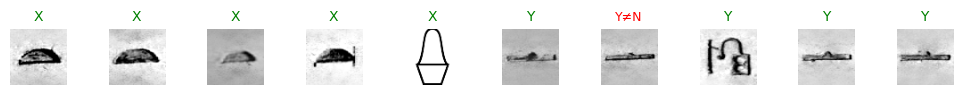

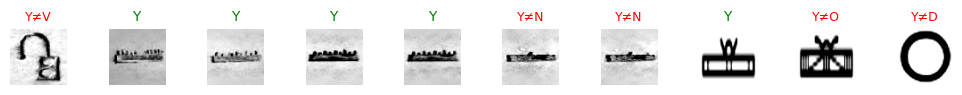

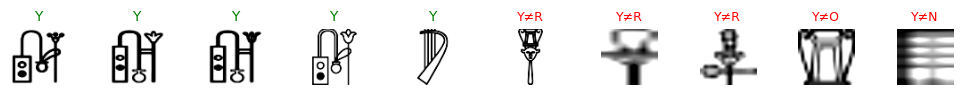

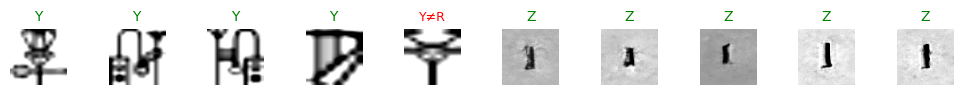

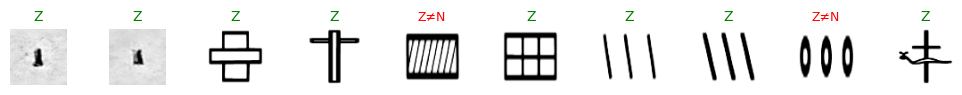

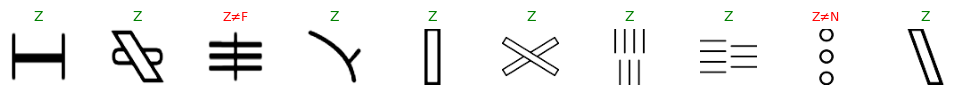

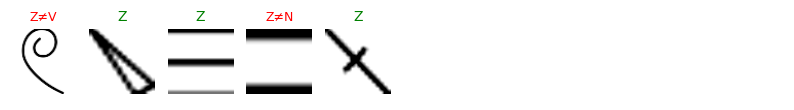

In [34]:
def display_result(dataset,preds):
    class_names = dataset.classes
    data_size = len(dataset)
    
    column = 10
    fig_id = 0
    for data,pred_id in zip(dataset,preds):

        if fig_id%column==0:
            fig, axs = plt.subplots(1,column, figsize=(column,1)) 
            for c in range(column):
                axs[c].axis('off')
            
        image,class_id = data
        numpy_image = image.numpy()
        numpy_image = numpy_image.transpose(1, 2, 0)
        ax = axs[fig_id%column]
        ax.imshow(numpy_image)
        if class_id == pred_id:
            ax.set_title( f"{class_names[class_id]}", color="green",fontsize=10)
        else:
            ax.set_title( f"{class_names[class_id]}≠{class_names[pred_id]}", color="red",fontsize=9)

        if fig_id%column == column-1:
            plt.tight_layout()
            plt.show()
        
        fig_id+=1

        



    
display_result(valid_dataloader.dataset,preds)


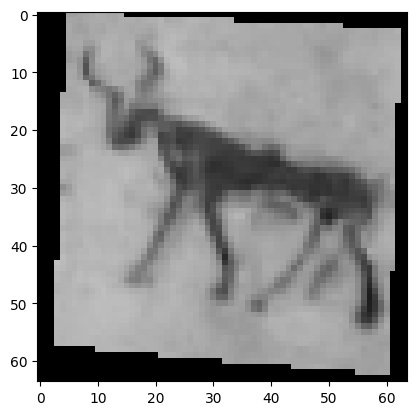

In [31]:
import copy
train_transform = transforms.Compose([
    transforms.Resize([64,64]),
    transforms.Grayscale(num_output_channels=3),
    transforms.ColorJitter(brightness=(0.8, 1.2),contrast=(0.6, 2)),
    AddGaussianNoise(mean=0, variance=random.uniform(0.1,0.5), amplitude=random.uniform(1,10),p=0.3),  
    transforms.RandomApply(torch.nn.ModuleList([ 
        transforms.GaussianBlur(5, sigma=(0.1,2)),
        transforms.RandomAffine(degrees=0,scale=(0.9, 1.1),translate=(0, 0.1)),
        transforms.RandomRotation(10),
    ])),
    
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomPerspective(distortion_scale=random.uniform(0,0.3), p=0.3)
    ])
img = Image.open("./test.png")
e = train_transform(img)
plt.imshow(e)

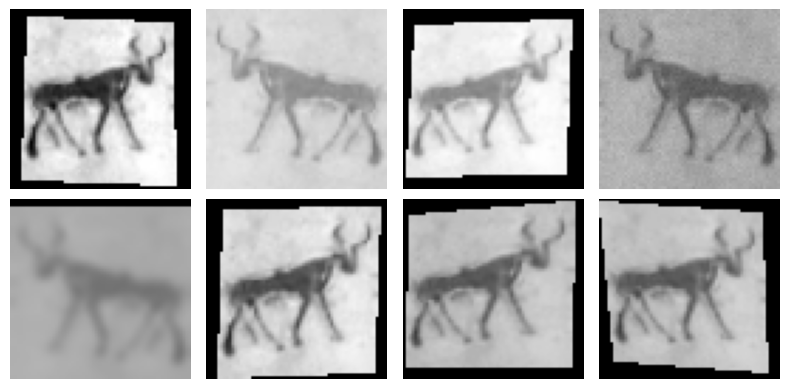

In [32]:


fig, axs = plt.subplots(2,4, figsize=(8,4))
for w in range(4):
    for k in range(2):
        axs[k,w].axis('off')
        axs[k,w].imshow(train_transform(img))



plt.tight_layout()
plt.show()